# ColSmolVLM prompt test
* check how colsmolvlm prompts image input inside the processor
* https://github.com/illuin-tech/colpali/blob/70614def40c8480253dca041fa22f45839e91ef7/colpali_engine/models/idefics3/colidefics3/processing_colidefics3.py#L27


model: `vidore/colSmol-500M`
* https://huggingface.co/vidore/colSmol-500M
* `SmolVLM-500M` model trained for visual retrieval

## Resources
* Scaling PDF Retrieval with Qdrant
    * https://colab.research.google.com/github/qdrant/examples/blob/master/pdf-retrieval-at-scale/ColPali_ColQwen2_Tutorial.ipynb

In [1]:
import json
import os

from PIL import Image

from config import settings

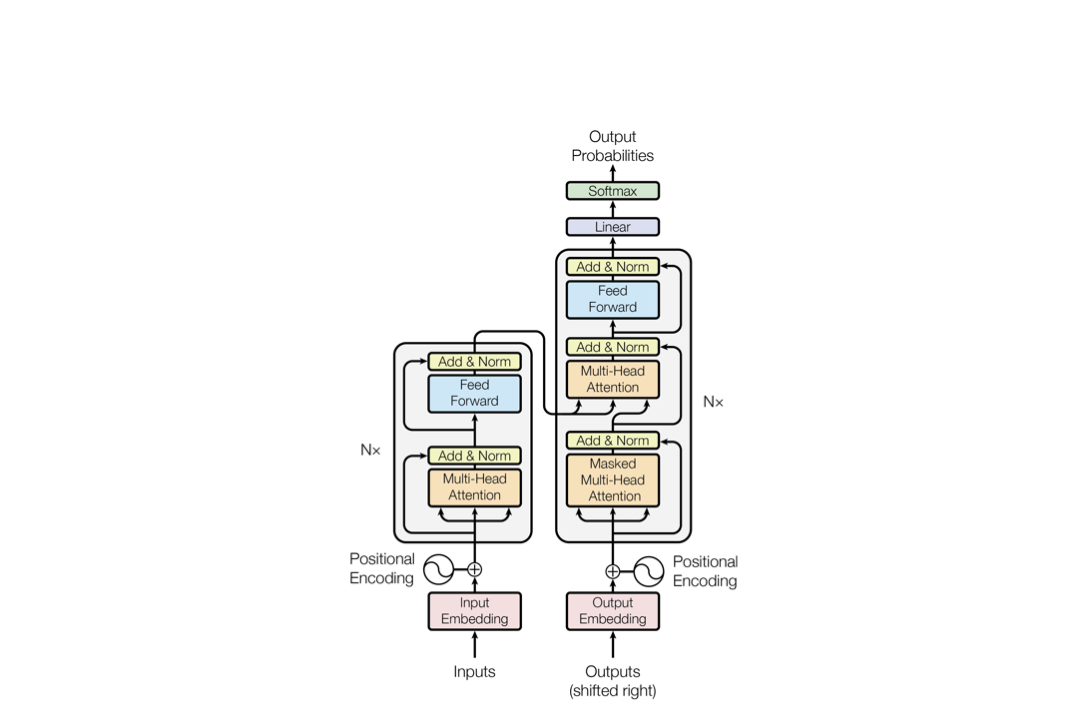

In [72]:
# Load Image
image = Image.open("../samples/1706.03762v7_p3.png").convert("RGB")
image
width, height = image.size
upper_half = image.crop((0, 0, width, height//2))
upper_half

In [73]:
## Load Model
import torch
from transformers import AutoTokenizer
from colpali_engine.models import ColIdefics3, ColIdefics3Processor

# Load Colpali engine
model_dir = os.path.join(
    settings.model_weight_dir, "multimodal_retriever/colSmol-500M"
)

model = ColIdefics3.from_pretrained(
    model_dir,
    torch_dtype=torch.bfloat16,
).eval()
model.to("mps")
tokenizer = AutoTokenizer.from_pretrained(model_dir)
processor = ColIdefics3Processor.from_pretrained(model_dir)

Some kwargs in processor config are unused and will not have any effect: image_seq_len. 


## ColIdefics3Processor
inside process_image:
* make messages template
* calls `self` to format into tokens

simplified flow:
```
messages_doc = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Describe the image."},
            {"type": "image"},
        ],
    },
]
text_doc=self.apply_chat_template(messages_doc, add_generation_prompt=False)
batch_doc = self(
    text=[text_doc],
    images=[images],
    return_tensors="pt",
    padding="longest",
)
```

In [74]:
processed = processor.process_images([upper_half])
print(processed.keys())

dict_keys(['pixel_values', 'pixel_attention_mask', 'input_ids', 'attention_mask'])


In [75]:
print(processed['input_ids'][0][:20])

tensor([    1, 11126,    42, 20263,   260,  2443,    30, 49189, 49153, 49190,
        49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190])


In [76]:
## Mask for image tokens
print(processor.image_token)
image_token_id = processor.tokenizer.convert_tokens_to_ids([str(processor.image_token)])[0]
print(image_token_id)
image_mask = processed['input_ids'][0] == image_token_id
print(image_mask[:20])

<image>
49190
tensor([False, False, False, False, False, False, False, False, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True])


In [77]:
print(processed['pixel_attention_mask'].shape)

torch.Size([1, 13, 512, 512])


## Embedding

In [78]:
## calculate embedding
embeddings = model(**processed.to("mps"))

In [79]:
type(embeddings)

torch.Tensor

In [80]:
print(embeddings.shape)
image_embedding = embeddings[0][image_mask]
print(image_embedding.shape)
x_patches=13
y_patches=3
print(image_embedding.view(x_patches, y_patches, model.dim))

torch.Size([1, 870, 128])
torch.Size([832, 128])


RuntimeError: shape '[13, 3, 128]' is invalid for input of size 106496

In [51]:
print(model.dim)
print(model.model.vision_model.patch_size)
print(upper_half.size)

128
16
(1088, 704)


In [59]:
# https://github.com/huggingface/transformers/blob/1feebb5b4150882deabddd190a541f336f3be817/src/transformers/models/idefics3/modeling_idefics3.py#L130
print(model.model.vision_model.embeddings.patch_size)
print(model.model.vision_model.embeddings.num_patches)
print(model.model.vision_model.embeddings.num_patches_per_side)

16
1024
32


In [82]:
# Get Patches
# def get_patches(image_size, processor, model):
#     # return processor.get_n_patches(
#     #     image_size, 
#     #     patch_size=model.model.vision_model.patch_size
#     # )
#     patch_size = model.model.vision_model.patch_size
#     n_patches_x = image_size[0] // patch_size
#     n_patches_y = image_size[1] // patch_size
#     return n_patches_x, n_patches_y
    
def get_n_patches(pixel_values: torch.Tensor, patch_size: int) -> int:
    """
    Given an image tensor of shape (B, C, H, W) or (C, H, W), determine the total number
    of patches generated by a patch embedding layer with a given patch size.
    
    Args:
        pixel_values (torch.Tensor): Input image tensor. Can be either 3D (C, H, W) or 4D (B, C, H, W).
        patch_size (int): The size (both height and width) of each patch.
        
    Returns:
        int: The total number of patches per image.
    """
    num_images, channels, height, width = pixel_values.shape

    # Compute the number of patches per image along each spatial dimension.
    patches_per_dim_height = height // patch_size
    patches_per_dim_width = width // patch_size

    return patches_per_dim_width, patches_per_dim_height


print(processed['pixel_values'][0].shape)
# x_patches, y_patches = get_patches(upper_half.size, processor, model)
x_patches, y_patches = get_n_patches(
    processed['pixel_values'][0], model.model.vision_model.patch_size
)
print(x_patches, y_patches)

torch.Size([13, 3, 512, 512])
32 32


In [53]:
# (x_patches, y_patches, 128)
image_patch_embeddings = image_embedding[image_mask].view(x_patches, y_patches, model.dim)

RuntimeError: shape '[68, 44, 128]' is invalid for input of size 106496